<a href="https://colab.research.google.com/github/tfredrick112/Hands-On-ML/blob/master/California_Housing_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!nvidia-smi

Mon Jan 20 04:49:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

First import all the essential libraries.

In [0]:
import sys
import os

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# to ignore unimportant warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Set the label sizes for the plots

In [0]:
%matplotlib inline

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

Download the data

In [0]:
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
# the url and the path have already been passed as default arguments
fetch_housing_data()

In [0]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [64]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can use the info() function to get to know how many rows of data we have, the column names, data type of each column and also the number of non-null entries in each column

In [65]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The value_counts() function can be used to see how many records belong to the categories in the 'ocean_proximity' column.

In [66]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Further insights into the values of each column can be obtained by using the describe function.

In [67]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In order to obtain a general idea of the distribution of the data in all the columns, we can plot histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1e38e01d0>,
      dtype=object)

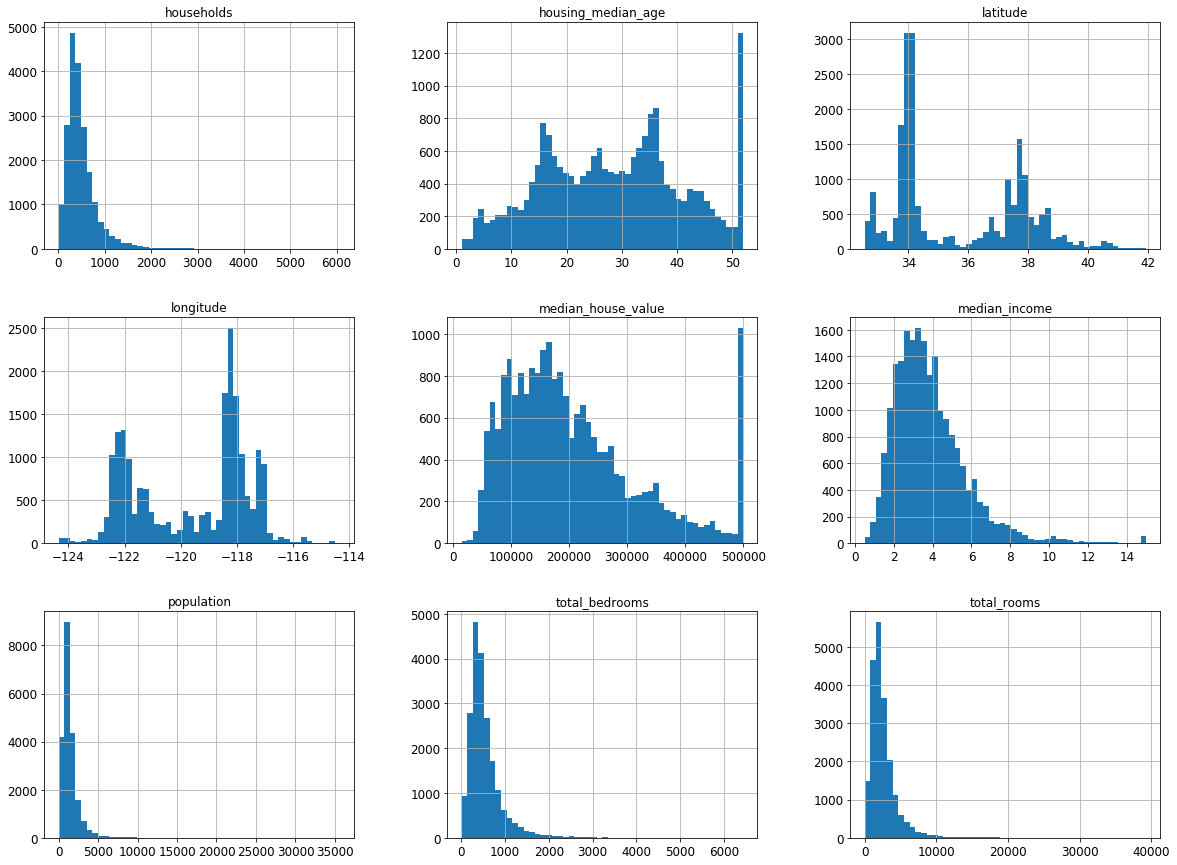

In [68]:
housing.hist(bins=50, figsize=(20,15))

Most of the histograms are tail-heavy, we will have to deal with this skew in the data before we begin the actual training. Also note that the housing_median_age and the median_house_value have been capped at 50 and $500,000, hence the tall bar in the histogram for these two columns (in the right portion).

We must split the dataset into a training set and a test set using the train_test_split function from sklearn.model_selection.

In [0]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [70]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [71]:
print("Number of examples in the training set = ", train_set.shape[0])
print("Number of examples in the test set = ", test_set.shape[0])

Number of examples in the training set =  16512
Number of examples in the test set =  4128


Randomly splitting the data as I did above can lead to sampling bias. If we assume that median income is a very important feature in the prediction of housing prices, we can use stratified sampling based on the median income. Let us see the distribution of the median income of the entire dataset.

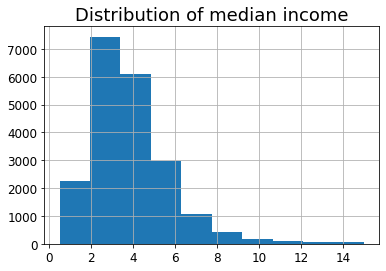

In [72]:
housing['median_income'].hist()
plt.title("Distribution of median income", size=18)
plt.show()

Most of the values lie between 1.5 and 6. I am going to define a new column (categorical) called income_cat and divide the examples into 5 categories.

In [0]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [74]:
housing['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

Text(0.5, 0, 'Income categories')

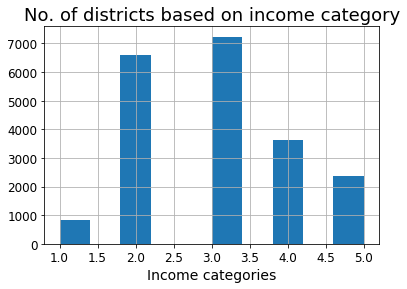

In [75]:
housing['income_cat'].hist()
plt.title('No. of districts based on income category', size=18)
plt.xlabel('Income categories', size=14)

We can now divide the housing dataset using stratified random sampling, so that the fraction of dsitricts belonging to various income categories will be identical in the training set and the test set. For example, if the training set contains districts belonging to the five income categories in the ratio: {1: 50%, 2: 10%, 3: 20%, 4:15%, 5:5%}, the test set must also have the same proportion.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

Let us check the fraction of each income category in the training set.

In [77]:
strat_train_set['income_cat'].value_counts()/strat_train_set.shape[0]

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Let us check the fraction of each income category in the test set.

In [78]:
strat_test_set['income_cat'].value_counts()/strat_test_set.shape[0]

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Remove the income_cat column, its purpose has been served.

In [0]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

### Visualizing the data

Text(0, 0.5, 'Longitude')

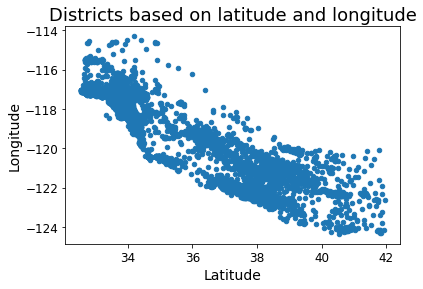

In [80]:
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='latitude', y='longitude')
plt.title("Districts based on latitude and longitude", size=18)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

To make the plot more informative, we can make regions with a higher density stand out.

Text(0, 0.5, 'Longitude')

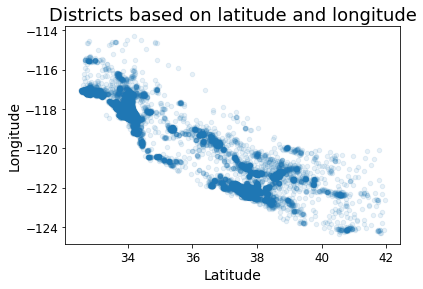

In [81]:
housing.plot(kind='scatter', x='latitude', y='longitude', alpha=0.1)
plt.title("Districts based on latitude and longitude", size=18)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

The size of the circles indicates population, the colour represents the house prices. 

Text(0.5, 1.0, 'Housing prices based on region')

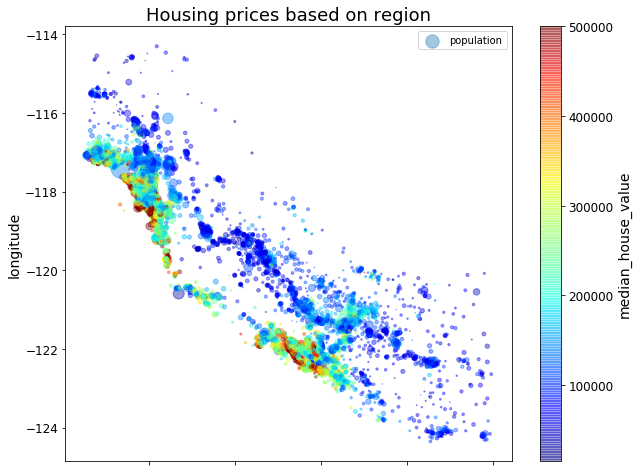

In [82]:
housing.plot(kind='scatter', x='latitude', y='longitude', alpha=0.4, s = housing['population']/100.0,
             label="population", figsize=(10,8),
              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.title('Housing prices based on region', size=18)

In [0]:
corr_matrix = housing.corr()

In [84]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

We can see that median_income, total_rooms and housing_median_age are positively correlated with the median_housing_value.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1e244ff60>,
      dtype=object)

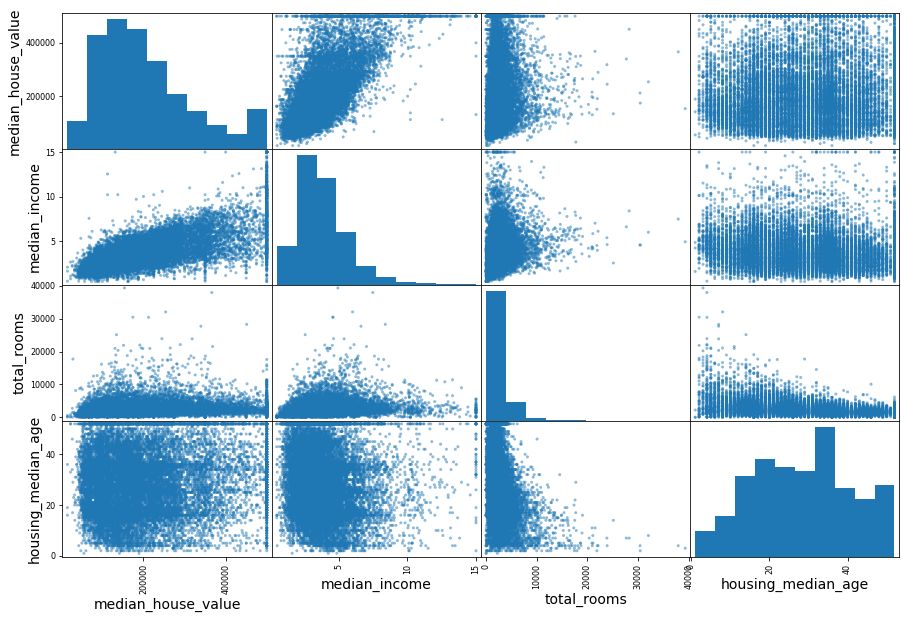

In [85]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(15,10))

We can see that there is a strong positive correlation between the median_income and the median_house_value. The cap at $500,000 is clearly visible.

### Creating new insightful attributes

It is more useful to know about the number of rooms in a house, rather than the total number of rooms in each district. The average bedroom/room ratio is also a good attribute. If it is low, it means that the average house has other rooms like a living room, kitchen, utility, etc. in addition to bedrooms, making the size, and hence the price, of the house greater.

In [0]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [0]:
corr_matrix = housing.corr()

In [88]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

As expected, rooms_per_household is more positively corelated with the median_house_value as compared to just the total_rooms. The negative correlation expected between bedrooms_per_room and median_house_value is also correct.

## Preparing the data for machine learning algorithms

In [0]:
housing = strat_train_set.drop('median_house_value', axis=1)
labels = strat_train_set['median_house_value'].copy()

There are missing values in the total_bedrooms column. There are three ways to deal with this issue:
* completely remove that attribute
* remove those districts where the attribute's value is missing
* fill up the missing values with the median.

I am going to use the third option.

In [0]:
median = housing['total_bedrooms'].median
housing['total_bedrooms'].fillna(median, inplace=True)

In [91]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null object
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(7), object(2)
memory usage: 1.3+ MB


In [0]:
housing = strat_train_set.drop('median_house_value', axis=1)
labels = strat_train_set['median_house_value'].copy()

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# as this imputer can be applied only on  numerical data, I will remove the ocean_proximity column
housing_num = housing.drop('ocean_proximity', axis=1)

In [93]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

Transform the training set

In [0]:
X = imputer.transform(housing_num)

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [0]:
housing_cat = housing[['ocean_proximity']]

In [97]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [98]:
# We can see the categories like so
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

When we use ordinal encoding, the machine is prone to assume that nearby values are similar, i.e., it will assume that the classes represented by 0 and 1 are more similar than those represented by 0 and 4, but we know that the opposite is the case. So it is better to use one-hot encoding.

In [99]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()

housing_cat_one_hot = one_hot_encoder.fit_transform(housing_cat)
housing_cat_one_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [100]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

Using the BaseEstimator and TransformerMixin classes as base classes lets us use the set_params, get_params and the fit_transform methods for free.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix]/X[:, households_ix]
    population_per_household = X[:, population_ix]/X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
      return np.c_[X, population_per_household, rooms_per_household, bedrooms_per_room]
    else:
      return np.c_[X, population_per_household, rooms_per_household]

attributes_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attributes_adder.fit_transform(housing.values)

In [102]:
housing_extra_attributes = pd.DataFrame(housing_extra_attributes,
                                        columns=list(housing.columns)+['population_per_household', 'rooms_per_household'],
                                        index=housing.index)
housing_extra_attributes.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,population_per_household,rooms_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2.0944,4.62537
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,2.70796,6.00885
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2.02597,4.22511
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,4.13598,5.23229
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3.04785,4.50581


## Transformation Pipelines

A pipeline for the numerical attributes

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('attr_adder', CombinedAttributesAdder()),
                         ('scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Using the ColumnTransformer class, it is possible to apply separate pipelines on the numerical columns and categorical columns.

In [0]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num) # list of the column names of numerical columns
cat_attributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attributes),
                                   ('cat', OneHotEncoder(), cat_attributes)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [105]:
housing_prepared.shape

(16512, 16)

## Training a model

In [106]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let us check the performance of the model.

In [107]:
some_data = housing_prepared[:5]
some_labels = labels.iloc[:5]

print("Predictions: {}".format(lin_reg.predict(some_data)))
print("True values : {}".format(list(some_labels)))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
True values : [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [108]:
from sklearn.metrics import mean_squared_error
predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
print("Root mean squared error: {}".format(rmse))

Root mean squared error: 68628.19819848923


The mean squared error on the training dataset is 68628.19819848923. The performance of the model is bad, as the rmse is itself comparable to the house prices.

This implies that we have a problem of underfitting. We must try to use a more complex model that can learn non-linear patterns in the data.

---



In [109]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, labels)

predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(labels, predictions)
tree_rmse = np.sqrt(tree_mse)
print("Root mean squared error (decision tree) ", tree_rmse)

Root mean squared error (decision tree)  0.0


The above value of RMSE = 0 actually indicates that the Decision Tree Regressor is seriously overfitting the data.

We will now use Cross Validation for better evaluation of the model performance. Cross Validation basically divides the training dataset into a smaller training set and a test set, and uses this test set for evaluation, so that the actual test set that was set aside initially, remains untouched.

In [112]:
from sklearn.model_selection import cross_val_score

# as cv = 10, the training and evaluation will happen 10 times, each time holding out
# 10% of the data as a cross-validation set.
# if cv = 20, the training and evaluation will happen 20 times, each time holding out
# 5% of the data as a cross-validation set.

scores = cross_val_score(tree_reg, housing_prepared, labels,
                          scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68601.5884602  68001.35592792 70647.54266749 69653.74102518
 71749.74701623 73482.72220591 72197.69233569 72103.94905842
 76550.83736046 68641.51462065]
Mean: 71163.06906781511
Standard deviation: 2493.3595339725075


We had obtained a training rmse of 0, but the cross validation rmse is high. This indicates overfitting.

We will now try to use a RandomForestRegressor. It trains many decision trees on random subsets of features and then takes the average of the results.

In [115]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, labels)

forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("RMSE of the RandomForestRegressor = ", forest_rmse)

scores = cross_val_score(forest_reg, housing_prepared, labels,
                          scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

RMSE of the RandomForestRegressor =  18848.030905357125
Scores: [49622.77233246 47940.2657159  50045.10706702 52488.66891567
 49857.36189043 53477.68399116 48606.27581009 48044.11634026
 53042.65606323 49921.50142772]
Mean: 50304.64095539251
Standard deviation: 1918.3000302914497


## Finetuning with GridSearchCV


In [117]:
from sklearn.model_selection import GridSearchCV
param_grid = [
                {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

We can directly get the best set of hyperparameters using grid_search.best_params_

In [118]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [119]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)